In [3]:
import gym
import tensorflow as tf
import numpy as np

In [4]:
env = gym.make('CartPole-v0')

In [5]:
import trfl

class QNetwork:
    def __init__(self, gamma=0.99, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, batch_size=20,
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [batch_size], name='actions')
            #one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            #self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            #Non trfl way from tutorial: https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
#             self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
#             self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
#             self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

            #TRFL way
            self.targetQs_ = tf.placeholder(tf.float32, [batch_size,action_size], name='target')
            self.reward = tf.placeholder(tf.float32,[batch_size],name="reward")
            self.discount = tf.constant(gamma,shape=[batch_size],dtype=tf.float32,name="discount")
      
            #TRFL qlearning
            qloss, q_learning = trfl.qlearning(self.output,self.actions_,self.reward,self.discount,self.targetQs_)
            self.loss = tf.reduce_mean(qloss)
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [4]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [78]:
train_episodes = 2          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 12               # number of units in each Q-network hidden layer
learning_rate = 0.001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 5                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [79]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, gamma=gamma, learning_rate=learning_rate,batch_size=batch_size)

In [80]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [82]:
# Now train with experiences
#saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
      
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                # Q値更新時にnext_stateがゼロのものを終端状態としQ値をゼロと置いている
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                # reward_punish = -100
                if t < 195:
                    reward = -300  # 報酬クリッピング、報酬は1, 0, -1に固定
                else:
                    reward = 1  # 立ったまま195step超えて終了時は報酬
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            print(target_Qs)
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            print(episode_ends)
            target_Qs[episode_ends] = (0, 0)
            
            #tutorial way
            #targets = rewards + gamma * np.max(target_Qs, axis=1)
#             loss, _ = sess.run([mainQN.loss, mainQN.opt],
#                                 feed_dict={mainQN.inputs_: states,
#                                            mainQN.targetQs_: targets,
#                                            mainQN.actions_: actions})

            #TRFL way, calculate td_error within TRFL
            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: target_Qs,
                                           mainQN.reward: rewards,
                                           mainQN.actions_: actions})
        
    #saver.save(sess, "checkpoints/cartpole.ckpt")

[[ 0.42325094 -0.28090397]
 [ 0.4801438  -0.3947437 ]
 [ 0.4806702  -0.345413  ]
 [ 0.26039726 -0.22456855]
 [ 0.14135072 -0.14640191]]
[False False False False False]
[[ 0.33580276 -0.2921669 ]
 [ 0.5485076  -0.4001471 ]
 [ 0.19954032 -0.14301927]
 [ 0.14885776 -0.1406927 ]
 [ 0.292374   -0.2220789 ]]
[False False False False False]
[[ 0.44626245 -0.26382565]
 [ 0.20804332 -0.13756497]
 [ 0.25036532 -0.2091289 ]
 [ 0.07866881  0.11827053]
 [ 0.34832662 -0.2839664 ]]
[False False False False False]
[[ 0.45870313 -0.25592825]
 [-0.01709201 -0.02578004]
 [ 0.63663745 -0.44404927]
 [ 0.21660687 -0.13225608]
 [ 0.41616517 -0.28552577]]
[False False False False False]
[[-0.01507652 -0.02282158]
 [ 0.65486836 -0.43305898]
 [ 0.27162686 -0.19621351]
 [ 0.07895436  0.12543312]
 [ 0.17412555 -0.12515883]]
[False False False False False]
[[ 0.31280112 -0.19173083]
 [ 0.08246012  0.1276824 ]
 [ 0.48459095 -0.24155757]
 [ 0.18296066 -0.12082678]
 [ 0.67369515 -0.4236861 ]]
[False False False False

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0, 0.5, 'Total Reward')

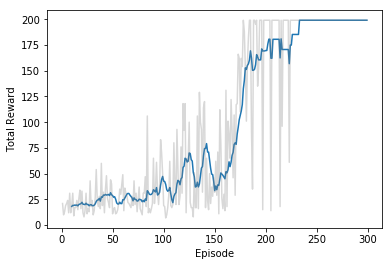

In [63]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')